## Step 1: Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from matplotlib import pyplot
import time
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

## Step 2: Loading dataset

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")
# !unzip /content/gdrive/MyDrive/ASL\ Sign\ language.zip
# /content/gdrive/MyDrive/ASL Sign language.zip
!unzip /content/gdrive/My\ Drive/ASL\ alphabet.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset5/E/u/color_20_0231.png  
  inflating: dataset5/E/u/color_20_0232.png  
  inflating: dataset5/E/u/color_20_0233.png  
  inflating: dataset5/E/u/color_20_0234.png  
  inflating: dataset5/E/u/color_20_0235.png  
  inflating: dataset5/E/u/color_20_0236.png  
  inflating: dataset5/E/u/color_20_0237.png  
  inflating: dataset5/E/u/color_20_0238.png  
  inflating: dataset5/E/u/color_20_0239.png  
  inflating: dataset5/E/u/color_20_0240.png  
  inflating: dataset5/E/u/color_20_0241.png  
  inflating: dataset5/E/u/color_20_0242.png  
  inflating: dataset5/E/u/color_20_0243.png  
  inflating: dataset5/E/u/color_20_0244.png  
  inflating: dataset5/E/u/color_20_0245.png  
  inflating: dataset5/E/u/color_20_0246.png  
  inflating: dataset5/E/u/color_20_0247.png  
  inflating: dataset5/E/u/color_20_0248.png  
  inflating: dataset5/E/u/color_20_0249.png  
  inflating: dataset5/E/u/color_20_0250.png  
  inflating: dataset5/E/u/col

### Transforming Dataset

In [3]:
# data_dir = "/content/Sign Language for Numbers";
# data_dir = "/content/gdrive/MyDrive/signs_train/asl_alphabet_train/asl_alphabet_train";
data_dir = "/content/dataset5/B";

In [4]:
transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.RandomVerticalFlip(0.2),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.ToTensor(),
# ])

dataset = ImageFolder(data_dir, transform = transform)

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

#No j & z
print("Number of classes: ",len(dataset.classes))
print("Number of images: ",len(dataset.samples))

Number of classes:  24
Number of images:  27820


In [6]:
# Splitting dataset into train, validation and test

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
extra_size = len(dataset) - train_size - val_size - test_size
train_ds, val_ds, test_ds, extra_size = random_split(dataset, [train_size, val_size, test_size, extra_size])
len(train_ds), len(val_ds), len(test_ds)

(19474, 5564, 2782)

In [7]:
# from torchvision.models import resnet18, ResNet18_Weights

# model = resnet18()

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
device = get_default_device()
device

device(type='cuda')

In [10]:
from torch.autograd import Variable
from torch.nn.modules import loss
from torch.optim.adam import Adam

def train_model(lr, batch_size, optimizer, loss_function, num_epochs, train_dl, test_dl, val_dl):
#Model Training and saving best Model
  best_accuracy = 0.0
  train_acc_list = []
  test_acc_list = []
  val_acc_list = []
  train_loss_list = []
  test_loss_list = []
  val_loss_list = []
  epo = []
  t1 = time.time()

  for epoch in range(num_epochs):
    # Train data set
    model.train()
    train_acc = 0.0
    train_loss = 0.0
    t2 = time.time()

    for i, (images, labels) in enumerate(train_dl):

        if(torch.cuda.is_available()):
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        # Forward pass
        outputs = model(images)
        loss = loss_function(outputs, labels)

        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Train accuracy
        train_loss += loss.item()*images.size(0)
        _,prediction=torch.max(outputs.data,1)

        train_acc += int(torch.sum(prediction==labels.data).item())

    train_acc = (train_acc / train_size)*100
    train_loss = train_loss / train_size

    # Test data set
    model.eval()
    test_acc = 0.0
    test_loss = 0

    for i, (images, labels) in enumerate(test_dl):

        if(torch.cuda.is_available()):
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        outputs = model(images)
        test_loss += loss.item()*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        test_acc += int(torch.sum(prediction==labels.data))

    test_acc = (test_acc / test_size)*100
    test_loss = test_loss / test_size

    # Validation data set
    val_acc = 0.0
    val_loss = 0

    for i, (images, labels) in enumerate(val_dl):

        if(torch.cuda.is_available()):
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        outputs = model(images)
        val_loss += loss.item()*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        val_acc += int(torch.sum(prediction==labels.data))

    val_acc = (val_acc / val_size)*100
    val_loss = val_loss / val_size

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    val_acc_list.append(val_acc)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    val_loss_list.append(val_loss)
    epo.append(epoch+1)

    print('Epoch[{}]({:.0f} sec)  Train Loss: {:.4f}, Train Accuracy:  {:.4f}, Test Loss: {:.4f}, Test Accuracy: {:.4f}, Val Loss: {:.4f}, Val Accuracy: {:.4f}\n'.format(epoch+1,time.time()-t2,train_loss,train_acc,test_loss,test_acc,val_loss,val_acc))
  print("######## Training Finished in {:.0f} seconds ###########".format(time.time()-t1))
  return train_acc_list, test_acc_list, val_acc_list, train_loss_list, test_loss_list, val_loss_list, epo

In [11]:
def place_graphs(lr, batch_size_arr, train_acc_arr, test_acc_arr, val_acc_arr, train_loss_arr, test_loss_arr, val_loss_arr, epo):
  plt.rcParams["figure.figsize"] = (20, 15)
  
  plt.subplot(3, 3, 1)
  plt.xticks(epo)
  for batch_size in batch_size_arr:
      plt.plot(epo, train_acc_arr[batch_size], label = "batch_size: " + str(batch_size))
      plt.legend(loc='best')
  # plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Train Accuracy vs. No. of epochs with lr: '+ str(lr));
  plt.grid()
  # plt.show()

  # plt.rcParams["figure.figsize"] = (20, 5)
  plt.subplot(3, 3, 2)
  plt.xticks(epo)
  for batch_size in batch_size_arr:
      plt.plot(epo, test_acc_arr[batch_size], label = "batch_size: " + str(batch_size))
      plt.legend(loc='best')
  # plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Test Accuracy vs. No. of epochs with lr: '+ str(lr));
  plt.grid()
  # plt.show()

  plt.subplot(3, 3, 3)
  plt.xticks(epo)
  for batch_size in batch_size_arr:
      plt.plot(epo, val_acc_arr[batch_size], label = "batch_size: " + str(batch_size))
      plt.legend(loc='best')
  # plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Validation Accuracy vs. No. of epochs with lr: '+ str(lr));
  plt.grid()
  # plt.show()

  plt.subplot(3, 3, 4)
  plt.xticks(epo)
  for batch_size in batch_size_arr:
      plt.plot(epo, train_loss_arr[batch_size], label = "batch_size: " + str(batch_size))
      plt.legend(loc='best')
  # plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Train Loss vs. No. of epochs with lr: '+ str(lr));
  plt.grid()
  # plt.show()

  plt.subplot(3, 3, 5)
  plt.xticks(epo)
  for batch_size in batch_size_arr:
      plt.plot(epo, val_loss_arr[batch_size], label = "batch_size: " + str(batch_size))
      plt.legend(loc='best')
  # plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Validation Loss vs. No. of epochs with lr: '+ str(lr));
  plt.grid()

  plt.show()

Lr: 0.01 batch size: 16
Epoch[1](63 sec)  Train Loss: 2.3664, Train Accuracy:  24.9101, Test Loss: 2.0068, Test Accuracy: 29.2595, Val Loss: 2.0068, Val Accuracy: 28.9899

Epoch[2](55 sec)  Train Loss: 1.4977, Train Accuracy:  51.0065, Test Loss: 3.7805, Test Accuracy: 56.1467, Val Loss: 3.7805, Val Accuracy: 55.8591

Epoch[3](56 sec)  Train Loss: 1.0551, Train Accuracy:  65.3127, Test Loss: 1.3011, Test Accuracy: 68.1165, Val Loss: 1.3011, Val Accuracy: 68.5838

Epoch[4](54 sec)  Train Loss: 0.8038, Train Accuracy:  73.3748, Test Loss: 0.4993, Test Accuracy: 78.2531, Val Loss: 0.4993, Val Accuracy: 78.1991

Epoch[5](55 sec)  Train Loss: 0.6398, Train Accuracy:  78.9925, Test Loss: 3.9198, Test Accuracy: 64.9533, Val Loss: 3.9198, Val Accuracy: 64.2883

Epoch[6](56 sec)  Train Loss: 0.5397, Train Accuracy:  81.7808, Test Loss: 1.5470, Test Accuracy: 75.6650, Val Loss: 1.5470, Val Accuracy: 75.7189

Epoch[7](54 sec)  Train Loss: 0.4770, Train Accuracy:  83.7424, Test Loss: 2.5641, Test 

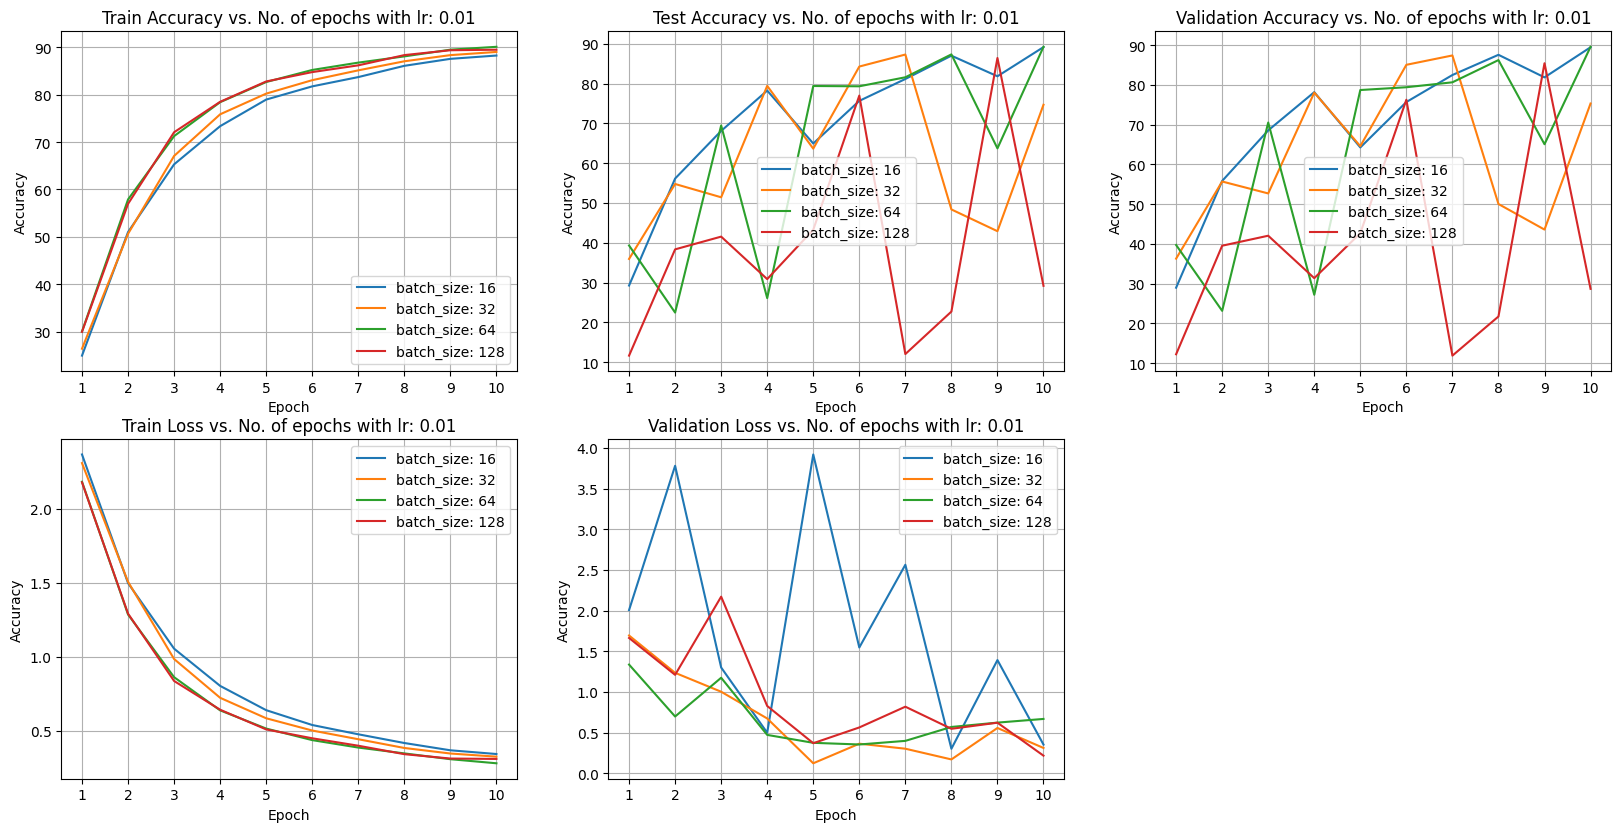

Lr: 0.001 batch size: 16
Epoch[1](57 sec)  Train Loss: 2.1046, Train Accuracy:  32.3662, Test Loss: 1.6879, Test Accuracy: 48.9935, Val Loss: 1.6879, Val Accuracy: 49.8023

Epoch[2](57 sec)  Train Loss: 1.1461, Train Accuracy:  62.4987, Test Loss: 2.4722, Test Accuracy: 50.7549, Val Loss: 2.4722, Val Accuracy: 52.6779

Epoch[3](57 sec)  Train Loss: 0.7288, Train Accuracy:  75.3672, Test Loss: 0.9684, Test Accuracy: 80.7333, Val Loss: 0.9684, Val Accuracy: 80.9490

Epoch[4](56 sec)  Train Loss: 0.5677, Train Accuracy:  81.2006, Test Loss: 0.8207, Test Accuracy: 77.6420, Val Loss: 0.8207, Val Accuracy: 78.7383

Epoch[5](57 sec)  Train Loss: 0.4822, Train Accuracy:  83.7578, Test Loss: 2.3186, Test Accuracy: 85.0467, Val Loss: 2.3186, Val Accuracy: 85.4781

Epoch[6](56 sec)  Train Loss: 0.4189, Train Accuracy:  86.1097, Test Loss: 4.0554, Test Accuracy: 88.3537, Val Loss: 4.0554, Val Accuracy: 86.8081

Epoch[7](57 sec)  Train Loss: 0.3601, Train Accuracy:  88.0148, Test Loss: 1.2945, Test

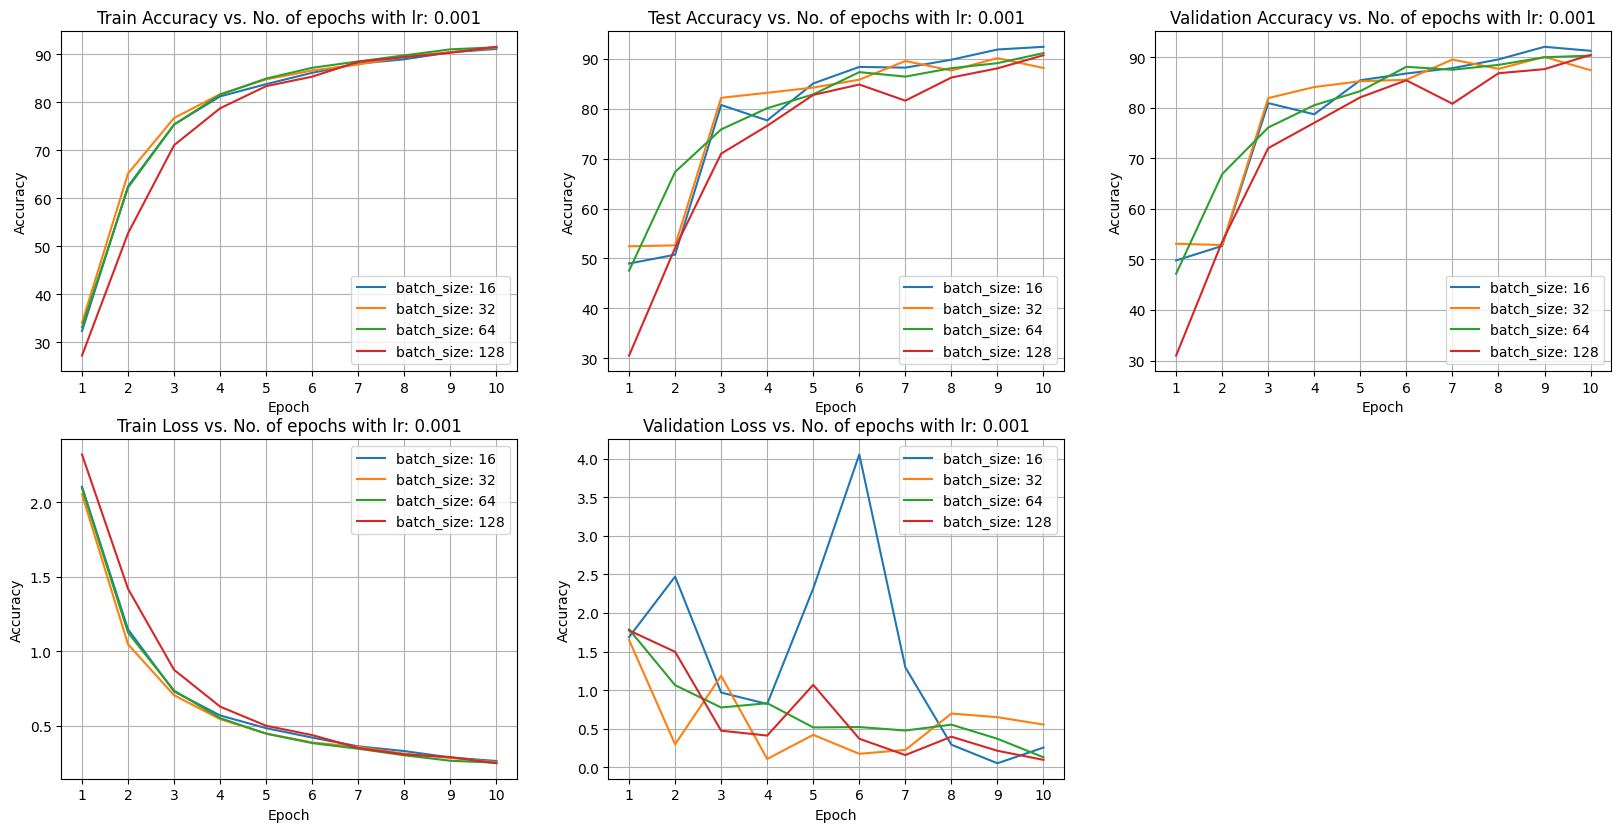

Lr: 0.0001 batch size: 16
Epoch[1](56 sec)  Train Loss: 2.6900, Train Accuracy:  18.9329, Test Loss: 3.0131, Test Accuracy: 25.5212, Val Loss: 3.0131, Val Accuracy: 27.8037

Epoch[2](56 sec)  Train Loss: 2.1005, Train Accuracy:  31.6062, Test Loss: 3.0840, Test Accuracy: 34.1121, Val Loss: 3.0840, Val Accuracy: 33.4472

Epoch[3](55 sec)  Train Loss: 1.7906, Train Accuracy:  41.0239, Test Loss: 2.3684, Test Accuracy: 49.6046, Val Loss: 2.3684, Val Accuracy: 51.9770

Epoch[4](55 sec)  Train Loss: 1.5028, Train Accuracy:  50.6830, Test Loss: 2.6763, Test Accuracy: 53.4148, Val Loss: 2.6763, Val Accuracy: 55.8411

Epoch[5](57 sec)  Train Loss: 1.2669, Train Accuracy:  58.4523, Test Loss: 2.3099, Test Accuracy: 64.4141, Val Loss: 2.3099, Val Accuracy: 66.0496

Epoch[6](57 sec)  Train Loss: 1.0663, Train Accuracy:  64.8814, Test Loss: 1.5117, Test Accuracy: 71.6032, Val Loss: 1.5117, Val Accuracy: 71.4594

Epoch[7](57 sec)  Train Loss: 0.8943, Train Accuracy:  70.9510, Test Loss: 3.4675, Tes

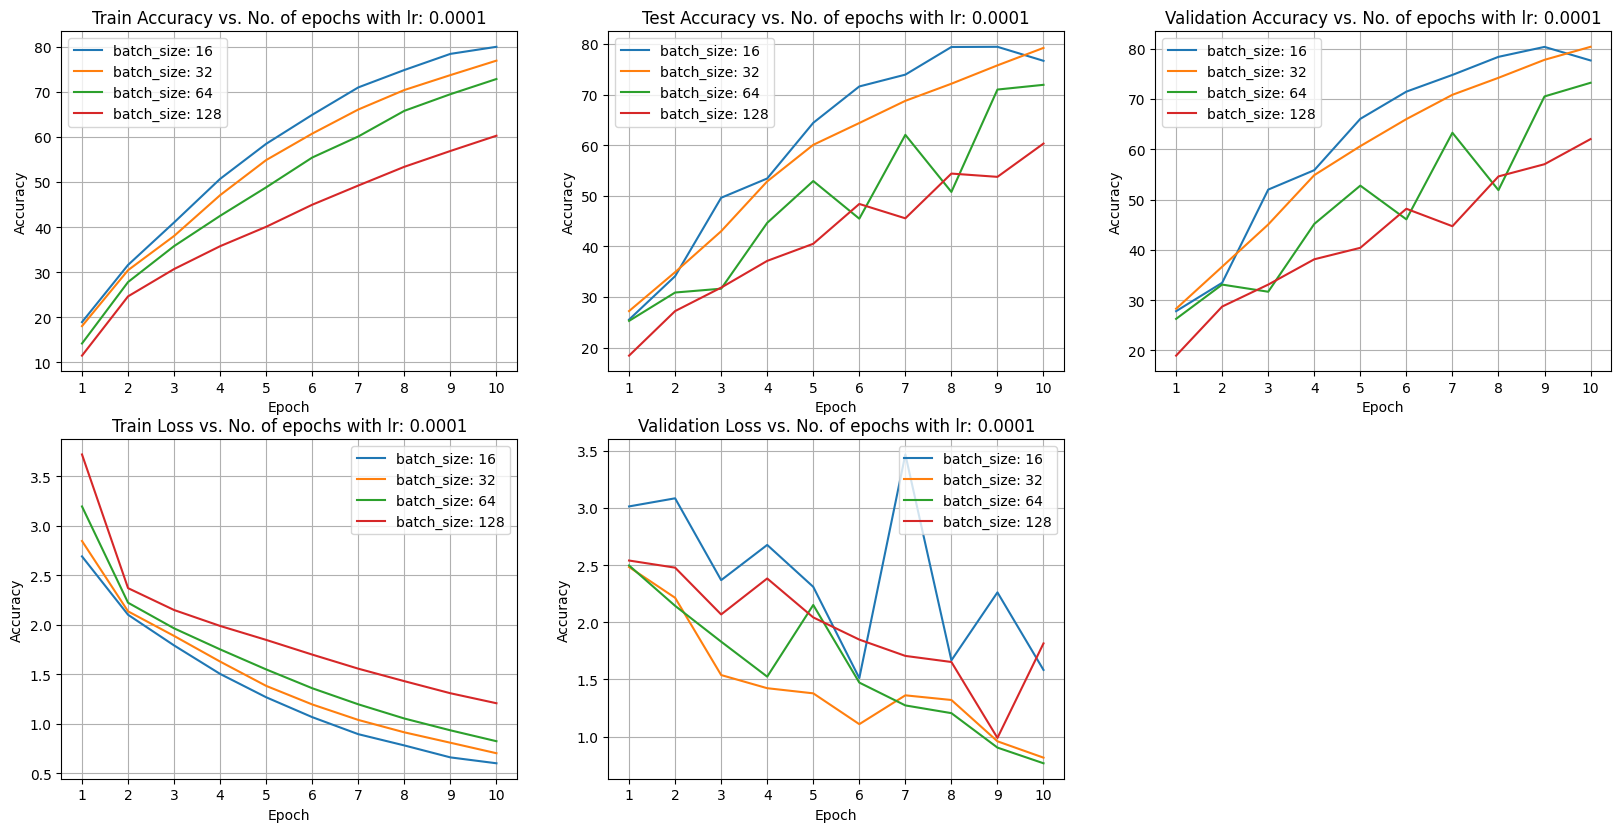

Lr: 1e-05 batch size: 16
Epoch[1](57 sec)  Train Loss: 4.3645, Train Accuracy:  6.3007, Test Loss: 3.3084, Test Accuracy: 11.2150, Val Loss: 3.3084, Val Accuracy: 12.0417

Epoch[2](55 sec)  Train Loss: 2.9602, Train Accuracy:  13.1457, Test Loss: 2.6553, Test Accuracy: 16.6068, Val Loss: 2.6553, Val Accuracy: 17.0561

Epoch[3](56 sec)  Train Loss: 2.6316, Train Accuracy:  18.6916, Test Loss: 2.8673, Test Accuracy: 20.3451, Val Loss: 2.8673, Val Accuracy: 20.6866

Epoch[4](56 sec)  Train Loss: 2.4877, Train Accuracy:  21.4388, Test Loss: 2.4440, Test Accuracy: 24.0115, Val Loss: 2.4440, Val Accuracy: 24.7304

Epoch[5](56 sec)  Train Loss: 2.3998, Train Accuracy:  23.4826, Test Loss: 2.2417, Test Accuracy: 25.2696, Val Loss: 2.2417, Val Accuracy: 26.7973

Epoch[6](57 sec)  Train Loss: 2.3473, Train Accuracy:  24.5045, Test Loss: 2.5361, Test Accuracy: 26.9231, Val Loss: 2.5361, Val Accuracy: 28.5945

Epoch[7](56 sec)  Train Loss: 2.2999, Train Accuracy:  25.7882, Test Loss: 3.8685, Test 

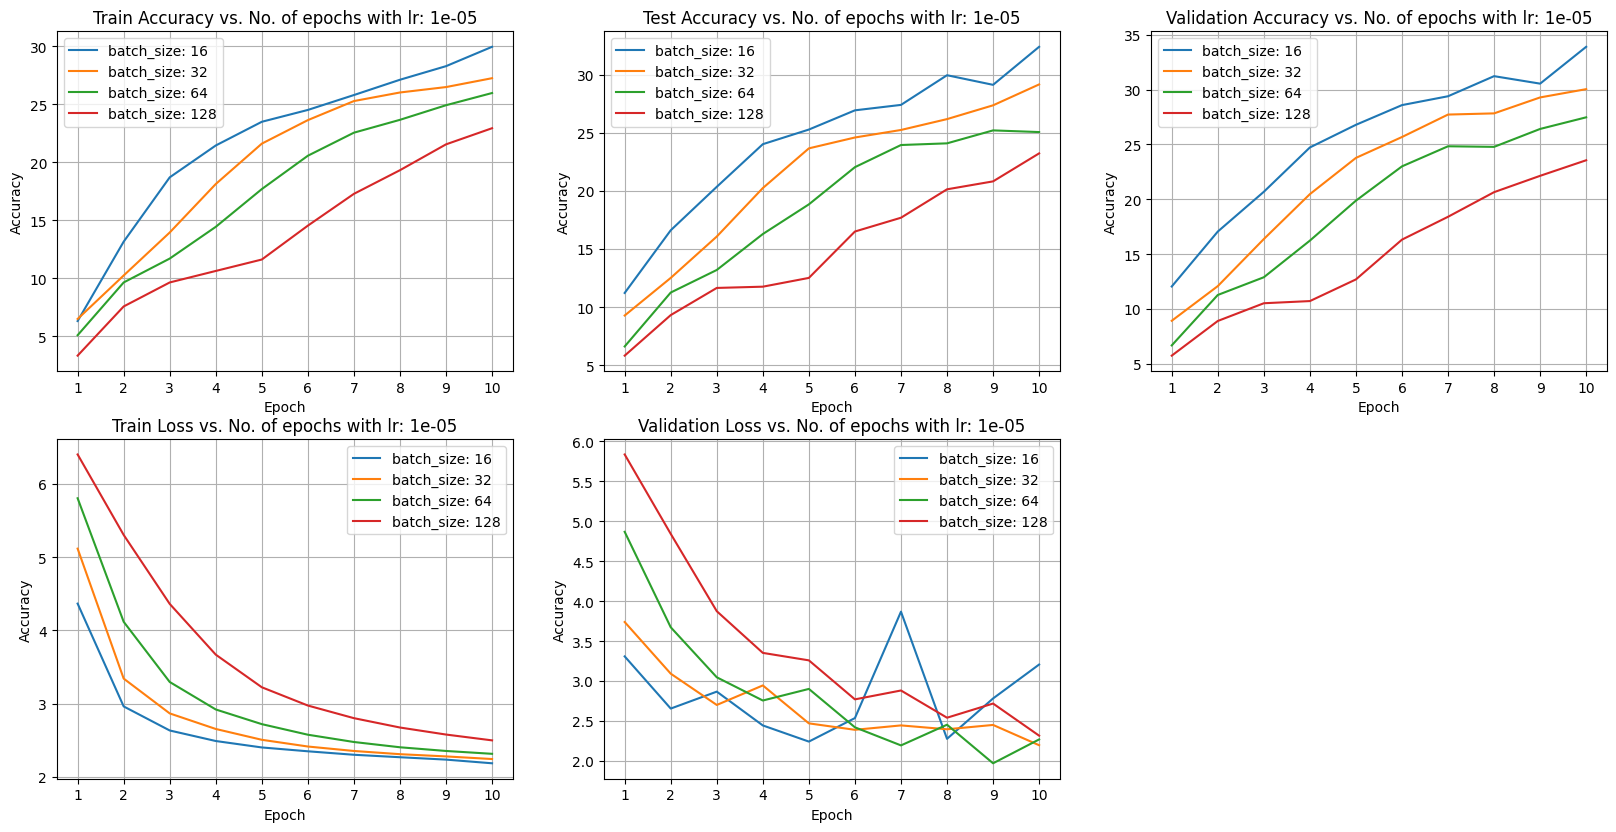

In [12]:
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision.models import resnet18, shufflenet_v2_x1_0

num_epochs = 10
lr_arr =  [0.01, 0.001, 0.0001, 0.00001]
batch_size_arr = [16, 32, 64, 128]
train_acc_arr = {}
test_acc_arr = {}
val_acc_arr = {}
train_loss_arr = {}
test_loss_arr = {}
val_loss_arr = {}
epo = []

for lr in lr_arr:

  for batch_size in batch_size_arr:

    model = shufflenet_v2_x1_0()

    print('Lr: {} batch size: {}'.format(lr, batch_size))

    train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
    test_dl = DataLoader(test_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
    val_dl = DataLoader(val_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

    train_dl = DeviceDataLoader(train_dl, device)
    test_dl = DeviceDataLoader(test_dl, device)
    val_dl = DeviceDataLoader(val_dl, device)
    to_device(model, device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss();

    train_acc_list, test_acc_list, val_acc_list, train_loss_list, test_loss_list, val_loss_list, epo = train_model(lr, batch_size, optimizer, loss_function, num_epochs, train_dl, test_dl, val_dl)

    train_acc_arr[batch_size] = train_acc_list
    test_acc_arr[batch_size] = test_acc_list
    val_acc_arr[batch_size] = val_acc_list
    train_loss_arr[batch_size] = train_loss_list
    test_loss_arr[batch_size] = test_loss_list
    val_loss_arr[batch_size] = val_loss_list

  place_graphs(lr, batch_size_arr, train_acc_arr, test_acc_arr, val_acc_arr, train_loss_arr, test_loss_arr, val_loss_arr, epo)

